Laboratorio 2 Computer Vision
- Sebastian Lopez
- Mateo Tapia

Importacion de paquetes usados en la tarea

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tensorflow.keras.datasets import cifar10
from matplotlib.colors import rgb_to_hsv
from scipy.ndimage import sobel as scipy_sobel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

In [46]:
# Cargar datos
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f'Tamaño de x_train: {x_train.shape}')
print(f'Tamaño de x_test: {x_test.shape}')
print(f'Tamaño de y_train: {y_train.shape}')
print(f'Tamaño de y_test: {y_test.shape}')

Tamaño de x_train: (50000, 32, 32, 3)
Tamaño de x_test: (10000, 32, 32, 3)
Tamaño de y_train: (50000, 1)
Tamaño de y_test: (10000, 1)


In [47]:
# Aplanar las etiquetas (vienen como matrices de 1 columna)
y_train = y_train.flatten()
y_test = y_test.flatten()
# Mostrar tamaños
print(f'Tamaño de x_train: {x_train.shape}')
print(f'Tamaño de x_test: {x_test.shape}')
print(f'Tamaño de y_train: {y_train.shape}')
print(f'Tamaño de y_test: {y_test.shape}')

Tamaño de x_train: (50000, 32, 32, 3)
Tamaño de x_test: (10000, 32, 32, 3)
Tamaño de y_train: (50000,)
Tamaño de y_test: (10000,)


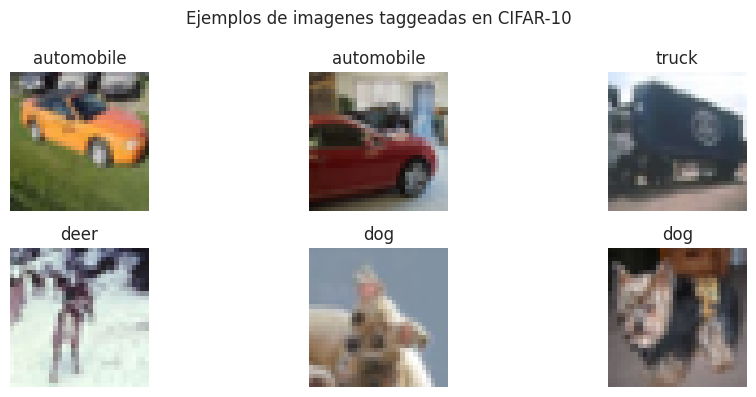

In [48]:
# Diccionario de nombres de clase
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Mostrar cimágenes aleatorias
idx = np.random.choice(len(x_train), 6, replace=False)
plt.figure(figsize=(10, 4))
for i, j in enumerate(idx):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_train[j])
    plt.title(class_names[y_train[j]])
    plt.axis('off')
plt.suptitle('Ejemplos de imagenes taggeadas en CIFAR-10')
plt.tight_layout()
plt.show()

# Ejercicio 1

## Cargar del dataset CIFAR-10 y extraer solo 3 clases para el entrenamiento

In [49]:

#Mapeo como dict de clases CIFAR-10
clases_nombres = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
    5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}

#Funcion de menu y seleccion de clases
def load_cifar10_subset_by_numbers():

    # Mostrar mapeo de clases
    print("Clases disponibles en CIFAR-10:")
    for k, v in clases_nombres.items():
        print(f"{k}: {v}")

    # Pedir 3 clases
    selected_indices = input("\n Ingresa 3 números de clases separados por comas (ejemplo: 0,1,2): ")
    selected_indices = [int(x.strip()) for x in selected_indices.split(",")]

    if len(selected_indices) != 3:
        raise ValueError("Debes seleccionar exactamente 3 clases.")

    # Cargamos el dataset
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    y_train = y_train.ravel()
    y_test  = y_test.ravel()

    # Filtramos en base a esas clases
    train_mask = np.isin(y_train, selected_indices)
    test_mask  = np.isin(y_test,  selected_indices)
    Xtr, ytr = X_train[train_mask], y_train[train_mask]
    Xte, yte = X_test[test_mask],  y_test[test_mask]

    # Remapeamos las etiquetas (0,1,2 en orden dado)
    remap = {orig: new for new, orig in enumerate(selected_indices)}
    ytr = np.vectorize(remap.get)(ytr)
    yte = np.vectorize(remap.get)(yte)

    # Nombres de clases seleccionadas
    class_names = [clases_nombres[i] for i in selected_indices]

    print("Clases elegidas:", class_names, "-> índices:", selected_indices)
    print(f"Train filtrado: X={Xtr.shape}, y={ytr.shape} (clases únicas: {np.unique(ytr)})")
    print(f"Test  filtrado: X={Xte.shape}, y={yte.shape} (clases únicas: {np.unique(yte)})")

    return Xtr, ytr, Xte, yte, class_names


# --- Ejecución de ejemplo ---
Xtr, ytr, Xte, yte, class_names = load_cifar10_subset_by_numbers()

Clases disponibles en CIFAR-10:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck
Clases elegidas: ['airplane', 'automobile', 'bird'] -> índices: [0, 1, 2]
Train filtrado: X=(15000, 32, 32, 3), y=(15000,) (clases únicas: [0 1 2])
Test  filtrado: X=(3000, 32, 32, 3), y=(3000,) (clases únicas: [0 1 2])


## Crear una función que extraiga 8 características de cada imagen (en este caso usaremos los canales R,G,B,H,S,V, bordes horizontales de sobel y bordes verticales de sobel )

In [50]:

def _to_float01(img):
    """Asegura rango [0,1] como float"""
    if img.dtype == np.uint8:
        return (img / 255.0).astype(np.float32)
    return img.astype(np.float32)

def _rgb_to_hsv_np(img_float01):
    """
    Convierte imagen RGB [0,1] a HSV [0,1] usando matplotlib.colors.rgb_to_hsv.
    img_float01: (H, W, 3) en [0,1]
    """

    hsv = rgb_to_hsv(img_float01)
    return hsv

def _sobel_xy_abs_mean(gray):
    """
    Calcula el promedio del valor absoluto de Sobel X e Y sobre imagen en escala de grises [0,1].
    Retorna: (mean_abs_sobel_x, mean_abs_sobel_y)
    """

    g = gray.astype(np.float32) # asegurar float32

    sx = scipy_sobel(g, axis=1, mode='reflect')
    sy = scipy_sobel(g, axis=0, mode='reflect')

    return float(np.mean(np.abs(sx))), float(np.mean(np.abs(sy)))

def extract_features_one(img_rgb):
    """
    Extrae 8 características de una imagen RGB:
    [meanR, meanG, meanB, meanH, meanS, meanV, mean|SobelX|, mean|SobelY|]

    img_rgb : np.ndarray, shape (H, W, 3), dtype uint8 o float en [0,1]

    Retorna: feats : np.ndarray, shape (8,), dtype float32
    """
    x = _to_float01(img_rgb)  # [0,1], float32

    # 1) Promedios RGB
    R_mean = float(np.mean(x[:, :, 0]))
    G_mean = float(np.mean(x[:, :, 1]))
    B_mean = float(np.mean(x[:, :, 2]))

    # 2) HSV y promedios H,S,V
    hsv = _rgb_to_hsv_np(x)  # [0,1]
    H_mean = float(np.mean(hsv[:, :, 0]))
    S_mean = float(np.mean(hsv[:, :, 1]))
    V_mean = float(np.mean(hsv[:, :, 2]))

    # 3) Sobel sobre escala de grises
    gray = (0.299 * x[:, :, 0] + 0.587 * x[:, :, 1] + 0.114 * x[:, :, 2]).astype(np.float32)
    sobel_x_mean_abs, sobel_y_mean_abs = _sobel_xy_abs_mean(gray)

    return np.array([R_mean, G_mean, B_mean, H_mean, S_mean, V_mean,
                     sobel_x_mean_abs, sobel_y_mean_abs], dtype=np.float32)

def extract_features_batch(X):
    """
    Extrae características para un batch de imágenes.

    X : np.ndarray, shape (N, H, W, 3)

    Retorna: F : np.ndarray, shape (N, 8)
    """
    N = X.shape[0]
    F = np.zeros((N, 8), dtype=np.float32)
    for i in range(N):
        F[i] = extract_features_one(X[i])
    return F

## Usar las características extraídas para entrenar el modelo de regresión logística, generar e imprimir un reporte de clasificación y una matriz de confusión.

Extrayendo características de train y test
Train feats: (15000, 8)
Test  feats: (3000, 8)

 Reporte de clasificación 
              precision    recall  f1-score   support

    airplane       0.69      0.68      0.69      1000
  automobile       0.74      0.77      0.76      1000
        bird       0.75      0.73      0.74      1000

    accuracy                           0.73      3000
   macro avg       0.73      0.73      0.73      3000
weighted avg       0.73      0.73      0.73      3000



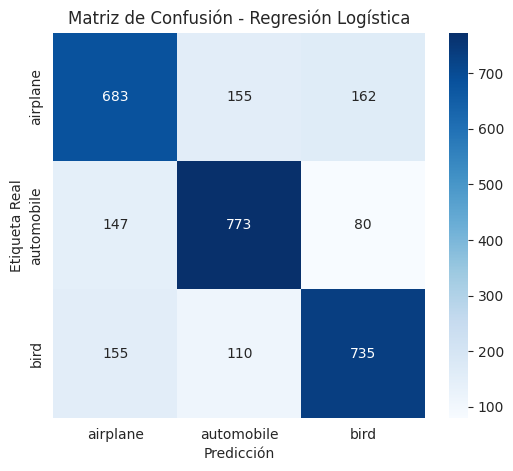

In [51]:

# Extraer características
print("Extrayendo características de train y test")
Xtr_feats = extract_features_batch(Xtr)
Xte_feats = extract_features_batch(Xte)

print("Train feats:", Xtr_feats.shape)
print("Test  feats:", Xte_feats.shape)

# Entrenar regresión logística
log_reg = LogisticRegression(
    max_iter=1000,   # iteraciones
    solver='saga',
    n_jobs=-1
)

log_reg.fit(Xtr_feats, ytr)

# Predicciones
y_pred = log_reg.predict(Xte_feats)

# Reporte de clasificación
print("\n Reporte de clasificación ")
print(classification_report(yte, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(yte, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

## Buscar una precisión mayor a 0.5 y variar hiperparámetros con la finalidad de mejorar la precisión.

>>> Buscando mejores hiperparámetros...
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/home/s.lopezmedina/Maestria/4_computer_vision/codigo/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/s.lopezmedina/Maestria/4_computer_vision/codigo/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/s.lopezmedina/Maestria/4_computer_vision/codigo/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the esti


=== Mejores hiperparámetros (CV) ===
{'clf__C': 3, 'clf__class_weight': None, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Mejor accuracy CV: 0.7345

Accuracy en Test (tuned): 0.7347

Classification Report (tuned)
              precision    recall  f1-score   support

    airplane       0.71      0.67      0.69      1000
  automobile       0.74      0.78      0.76      1000
        bird       0.75      0.75      0.75      1000

    accuracy                           0.73      3000
   macro avg       0.73      0.73      0.73      3000
weighted avg       0.73      0.73      0.73      3000



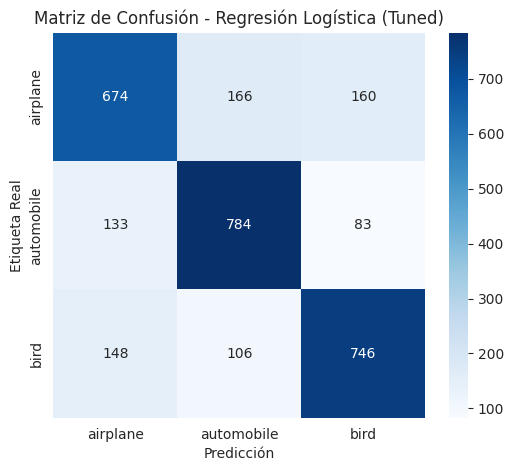

Objetivo logrado: precisión en test >= 0.5 con 0.73


In [52]:

# Pipeline: escalado + regresión logística
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
])

# Definir cuadrículas
param_grids = [
    # Multinomial con L2 (válido para lbfgs/newton-cg/saga)
    {
        "clf__solver": ["lbfgs", "newton-cg", "saga"],
        "clf__penalty": ["l2"],
        "clf__C": [0.01, 0.1, 1, 3, 10],
        "clf__class_weight": [None, "balanced"]
    },
    # One vs Rest con L1 (válido para liblinear/saga)
    {
        "clf__solver": ["liblinear", "saga"],
        "clf__penalty": ["l1"],
        "clf__C": [0.01, 0.1, 1, 3, 10],
        "clf__class_weight": [None, "balanced"]
    },
    # One vs Rest con L2 (válido para liblinear)
    {
        "clf__solver": ["liblinear"],
        "clf__penalty": ["l2"],
        "clf__C": [0.01, 0.1, 1, 3, 10],
        "clf__class_weight": [None, "balanced"]
    },
]

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search (buscar el mejor set por accuracy)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grids,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print(">>> Buscando mejores hiperparámetros...")
grid.fit(Xtr_feats, ytr)

print("\n=== Mejores hiperparámetros (CV) ===")
print(grid.best_params_)
print(f"Mejor accuracy CV: {grid.best_score_:.4f}")

# Evaluación en test con el mejor modelo
best_model = grid.best_estimator_
y_pred_tuned = best_model.predict(Xte_feats)
test_acc = accuracy_score(yte, y_pred_tuned)
print(f"\nAccuracy en Test (tuned): {test_acc:.4f}")

print("\nClassification Report (tuned)")
print(classification_report(yte, y_pred_tuned, target_names=class_names))

# Matriz de confusión del modelo afinado
cm = confusion_matrix(yte, y_pred_tuned)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión - Regresión Logística (Tuned)")
plt.show()

# Verificación del objetivo > 0.5
if test_acc >= 0.5:
    print(f"Objetivo logrado: precisión en test >= 0.5 con {test_acc:.2f}")


# Ejercicio 2

## Cargar del dataset CIFAR-10 y extraer solo 3 clases para el entrenamiento

In [53]:
# Usamos la misma funcion del primer ejercicio
Xtr, ytr, Xte, yte, class_names = load_cifar10_subset_by_numbers()

print("Clases seleccionadas:", class_names)
print("Shapes -> Xtr:", Xtr.shape, "ytr:", ytr.shape, "| Xte:", Xte.shape, "yte:", yte.shape)


Clases disponibles en CIFAR-10:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck
Clases elegidas: ['airplane', 'automobile', 'bird'] -> índices: [0, 1, 2]
Train filtrado: X=(15000, 32, 32, 3), y=(15000,) (clases únicas: [0 1 2])
Test  filtrado: X=(3000, 32, 32, 3), y=(3000,) (clases únicas: [0 1 2])
Clases seleccionadas: ['airplane', 'automobile', 'bird']
Shapes -> Xtr: (15000, 32, 32, 3) ytr: (15000,) | Xte: (3000, 32, 32, 3) yte: (3000,)


## Crear una función que extraiga 8 características de cada imagen

In [54]:
# Usamos la misma funcion del primer ejercicio

print("Extrayendo características")
Xtr_feats = extract_features_batch(Xtr)
Xte_feats = extract_features_batch(Xte)
print("Train feats:", Xtr_feats.shape, " Test feats:", Xte_feats.shape)


Extrayendo características
Train feats: (15000, 8)  Test feats: (3000, 8)


## Usar las características extraídas para “entrenar” el clasificador, generar e imprimir un reporte de clasificación y una matriz de confusión.

In [55]:

pipe_knn = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5, weights="distance", p=2))  # baseline razonable
])

pipe_knn.fit(Xtr_feats, ytr)


,steps,"[('scaler', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,5
,weights,'distance'
,algorithm,'auto'
,leaf_size,30


Accuracy Test (baseline KNN): 0.7333

              precision    recall  f1-score   support

    airplane       0.71      0.69      0.70      1000
  automobile       0.74      0.78      0.76      1000
        bird       0.75      0.73      0.74      1000

    accuracy                           0.73      3000
   macro avg       0.73      0.73      0.73      3000
weighted avg       0.73      0.73      0.73      3000



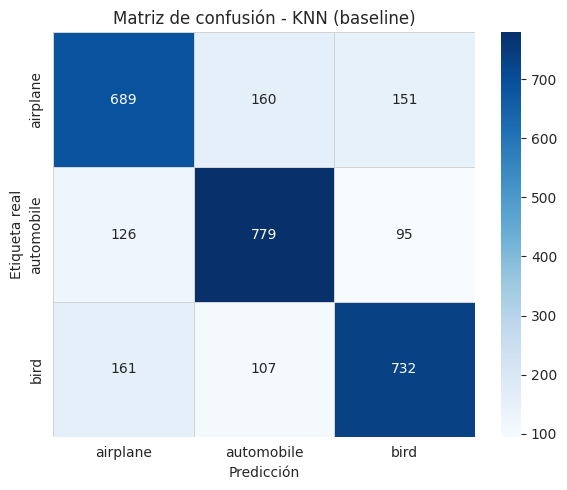

In [56]:

y_pred_base = pipe_knn.predict(Xte_feats)
acc_base = accuracy_score(yte, y_pred_base)
print(f"Accuracy Test (baseline KNN): {acc_base:.4f}\n")
print(classification_report(yte, y_pred_base, target_names=class_names))

# Matriz de confusión (usando seaborn.heatmap)
cm = confusion_matrix(yte, y_pred_base)

plt.figure(figsize=(6,5)) # Create a figure and an axes object
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            linewidths=.5, linecolor='lightgray') # Add lines between cells for clarity
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión - KNN (baseline)")
plt.tight_layout()
plt.show()

## Buscar una precisión mayor a 0.5 y variar hiperparámetros con la finalidad de mejorar la precisión.

Buscando mejores hiperparámetros para KNN...
Fitting 5 folds for each of 28 candidates, totalling 140 fits

 Mejores hiperparámetros (CV)
{'knn__n_neighbors': 21, 'knn__p': 2, 'knn__weights': 'distance'}
Mejor accuracy CV: 0.7455

Accuracy en Test (KNN afinado): 0.7520

              precision    recall  f1-score   support

    airplane       0.73      0.70      0.72      1000
  automobile       0.76      0.81      0.78      1000
        bird       0.77      0.74      0.75      1000

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000



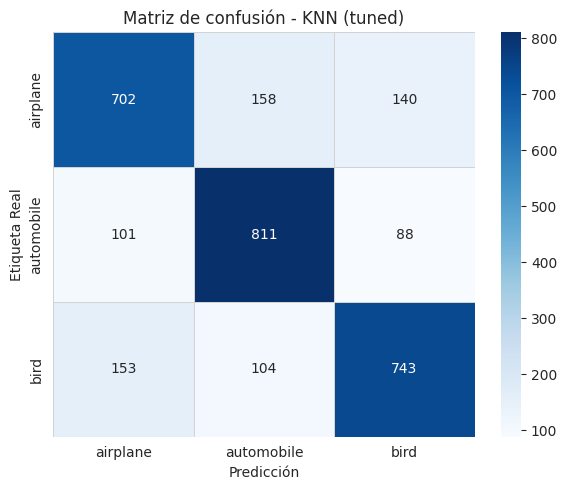

Objetivo logrado: precisión en test ≥ 0.5


In [57]:

param_grid_knn = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],  # Manhattan vs Euclidiana
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid_knn,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("Buscando mejores hiperparámetros para KNN...")
grid_knn.fit(Xtr_feats, ytr)

print("\n Mejores hiperparámetros (CV)")
print(grid_knn.best_params_)
print(f"Mejor accuracy CV: {grid_knn.best_score_:.4f}")

best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(Xte_feats)
acc_knn = accuracy_score(yte, y_pred_knn)
print(f"\nAccuracy en Test (KNN afinado): {acc_knn:.4f}\n")
print(classification_report(yte, y_pred_knn, target_names=class_names))

# Matriz de confusión del modelo afinado
cm = confusion_matrix(yte, y_pred_knn)
plt.figure(figsize=(6,5)) # Create a figure and an axes object
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            linewidths=.5, linecolor='lightgray') # Use seaborn.heatmap
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de confusión - KNN (tuned)")
plt.tight_layout()
plt.show()

if acc_knn >= 0.5:
    print("Objetivo logrado: precisión en test ≥ 0.5")


## Visualizar algunas 15 predicciones al azar.

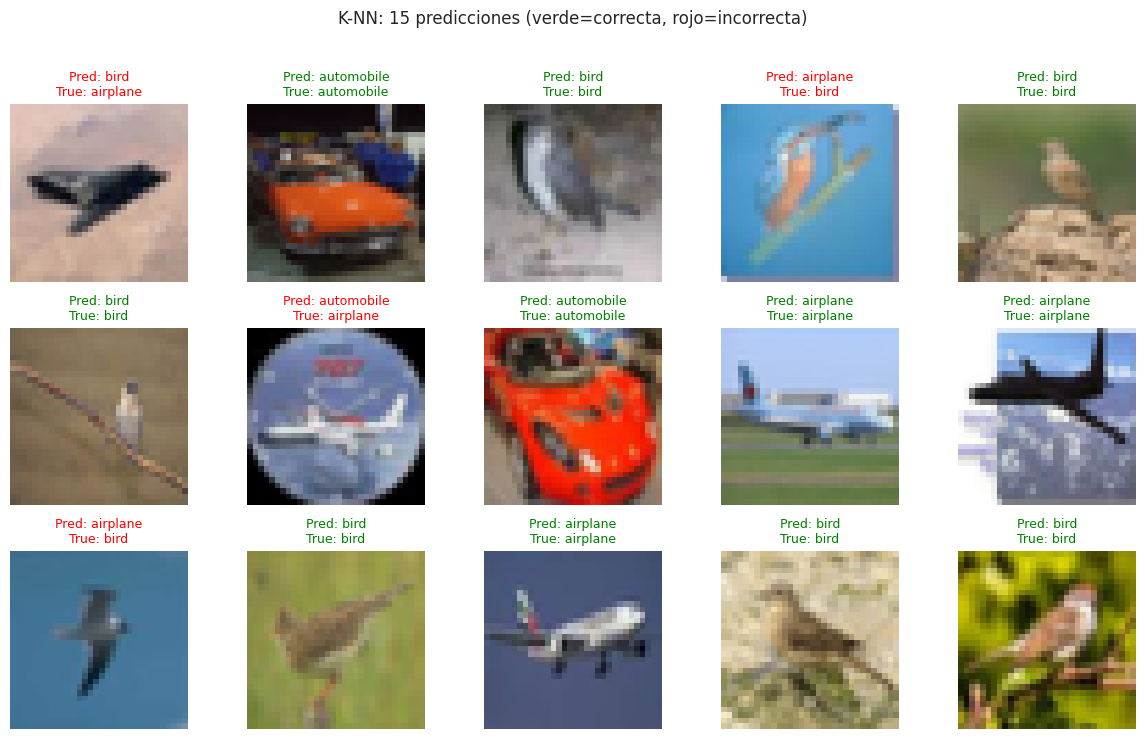

In [58]:
rng = np.random.default_rng(42)
idxs = rng.choice(len(Xte), size=15, replace=False)

n_cols = 5
n_rows = int(np.ceil(len(idxs) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.4*n_rows))
axes = np.array(axes).reshape(n_rows, n_cols)

for ax, idx in zip(axes.flat, idxs):
    img = Xte[idx]
    true_label = class_names[yte[idx]]
    pred_label = class_names[y_pred_knn[idx]]
    correct = (true_label == pred_label)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(
        f"Pred: {pred_label}\nTrue: {true_label}",
        color=("green" if correct else "red"),
        fontsize=9
    )

# Apaga ejes sobrantes si no llenas la grilla exacto
for k in range(len(idxs), n_rows*n_cols):
    axes.flat[k].axis("off")

plt.suptitle("K-NN: 15 predicciones (verde=correcta, rojo=incorrecta)", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()
